In [6]:
import numpy as np
import ast
import scipy   
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2     
from keras.preprocessing import image    
from keras.models import Model   
import sys
from labels import labels

In [7]:
img = cv2.imread("ski.jpg")
resized = cv2.resize(img, (224, 224))
reshaped = resized.reshape(1, 224, 224, 3)


In [8]:
model = tf.keras.applications.MobileNetV2()

In [9]:
out1 = model.layers[-3].output

out2 = model.layers[-1].output


model = tf.keras.Model(inputs=model.input, 
    outputs=(out1, out2)) 



In [10]:
all_amp_layer_weights = model.layers[-1].get_weights()[0]

In [13]:
last_conv_output, pred_vec = model.predict(reshaped)
# print(last_conv_output.shape)

# change dimensions of last convolutional outpu tto 7 x 7 x 2048
last_conv_output = np.squeeze(last_conv_output) 
# print(last_conv_output.shape)

# get model's prediction (number between 0 and 999, inclusive)
pred = np.argmax(pred_vec)
print(pred, pred_vec[0][pred],labels[pred])

# bilinear upsampling to resize each filtered image to size of original image 
mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

final_arr = []
threshold = 0.3

for val in pred_vec[0]:
    if val > threshold:
        index_of = np.where(pred_vec[0]==val)
        # get AMP layer weights
        amp_layer_weights = all_amp_layer_weights[:, index_of[0][0]] # dim: (2048,) 

        # get class activation map for object class that is predicted to be in the image
        final_output = np.dot(mat_for_mult.reshape((224*224, 1280)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
        final_arr.append(final_output)




794 0.9120393 shower curtain


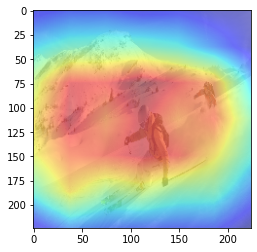

In [8]:
fig, ax = plt.subplots()

for item in final_arr:
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)

    # plot class activation map
    ax.imshow(final_arr[0], cmap='jet', alpha=0.5)